In [29]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import skimage
import skimage.io, skimage.transform, skimage.filters
import scipy.ndimage

import sys
sys.path.append(r'../src/')

import importlib
import transform
import filters
import local_radon
importlib.reload(transform)
importlib.reload(filters)
importlib.reload(local_radon)

<module 'local_radon' from '../src\\local_radon.py'>

D:/Data/bujo_sample\20190309_125151.jpg
Wall time: 1.01 s


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


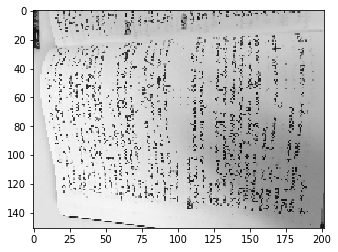

In [291]:
%%time
src_fname = os.path.join(cfg.sample_path, os.listdir(cfg.sample_path)[6])
print(src_fname)
src = skimage.io.imread(src_fname, as_grey=True)

src2 = skimage.transform.rescale(src, scale=0.05)
plt.imshow(src2, cmap='gray')

C:\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Text angles is 0.0
Text line delta is 9
Wall time: 882 ms


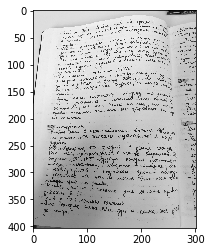

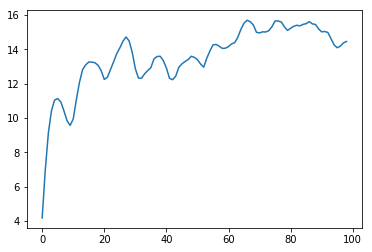

In [292]:
%%time
text_angle = transform.get_text_angle(src2)
print('Text angles is {}'.format(text_angle[0][0]))

src3 = skimage.transform.rotate(skimage.transform.rescale(src, scale=0.1), -90.0-text_angle[0][0], resize=True)
srcr = skimage.transform.rotate(src, -90.0-text_angle[0][0], resize=True)
plt.figure()
plt.imshow(src3, cmap='gray')

text_line_delta, text_line_deltas = transform.get_text_line_delta(src3)
plt.figure()
plt.plot(text_line_deltas)
print('Text line delta is {}'.format(text_line_delta))

Wall time: 79.1 ms


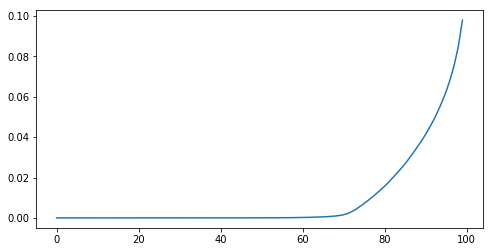

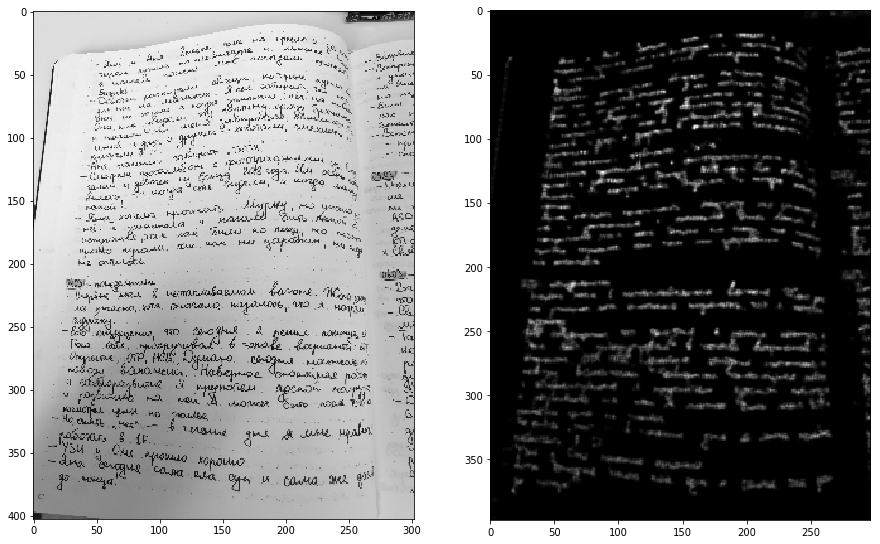

In [293]:
%%time
src4 = transform.filter_variance(src3, (text_line_delta//2, text_line_delta//2), 50, 50)
text_cutoff = np.percentile(src4, 90)/2

plt.figure(figsize=(8,4))
plt.plot(np.percentile(src4, range(100)))

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(src3, cmap='gray')
plt.subplot(122)
plt.imshow(src4, cmap='gray')

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[(-1.5466302294595904, -64.0, 0, 162, 1677)]
Wall time: 100 ms


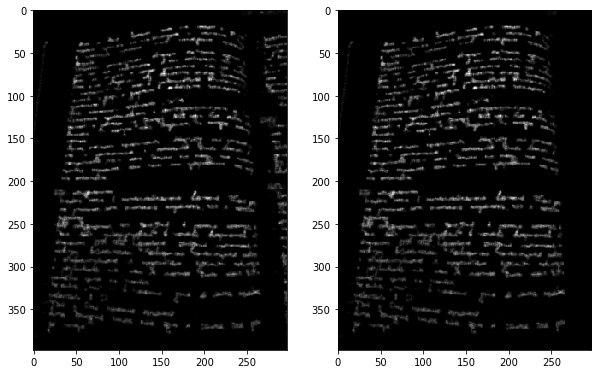

In [294]:
%%time
src5 = skimage.transform.rescale(src4>text_cutoff, scale=0.25)>0.0
src6 = skimage.filters.gaussian(src5, sigma=0.2)>0.4

vsplits = transform.search_region_vsplit(src6, np.pi*3/8, num_angles=131,
                                         window_size_1d=15, max_value=2, zero_threshold=10,
                                         min_split_abs=100, max_split_pct=0.10)

src7 = transform.erase_regions(src4, vsplits, dsz=4)
print(vsplits)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(src4, cmap='gray')
plt.subplot(122)
plt.imshow(src7, cmap='gray')

Wall time: 983 ms


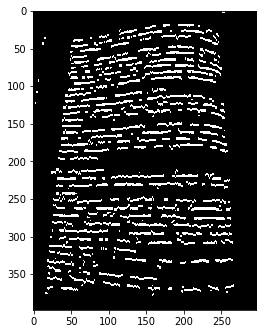

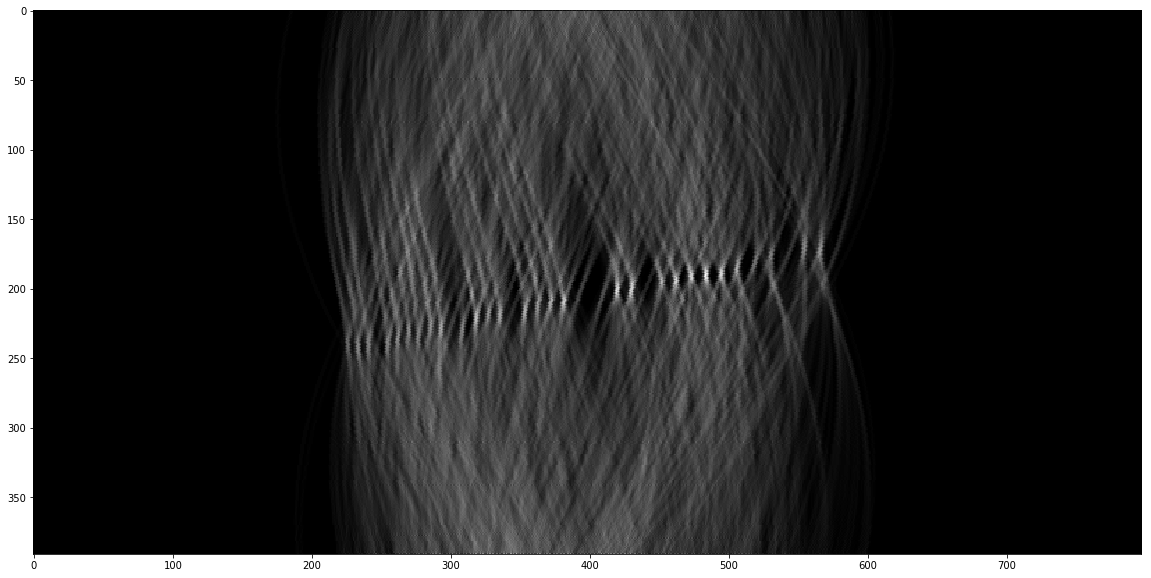

In [295]:
%%time
src8 = filters.local_maxima_v(src7, 1, text_line_delta//2, text_cutoff)*1.0

theta = np.linspace(-np.pi/4, np.pi/4, 391)
rgrid = local_radon.create_grid(src8, theta)
src9 = local_radon.calc_local_radon(rgrid, src8, 0, src8.shape[0], 0, src8.shape[1])

plt.figure(figsize=(4,10))
plt.imshow(src8, cmap='gray')

plt.figure(figsize=(20,10))
plt.imshow(src9, cmap='gray')

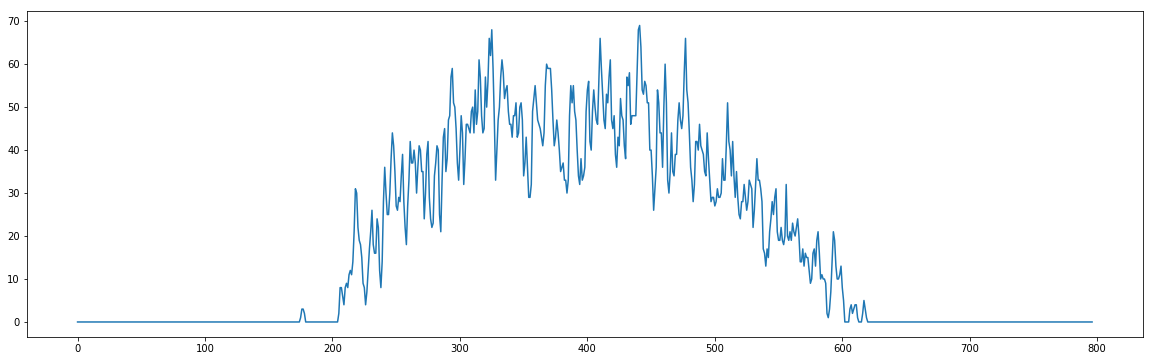

In [296]:
plt.figure(figsize=(20,6))
plt.plot(src9[50,:])

In [272]:
def search_textline_1d(arr1d, filter_width, min_maxima, max_minima, minmax_dist):
    ids1 = local_radon.get_local_maximas_1d(arr1d, filter_width, min_maxima)
    mins = scipy.ndimage.minimum_filter1d(arr1d, size=filter_width, mode='nearest')
    ids2 = [(j, arr1d[j], max(mins[max(0, j-(filter_width//2))], mins[min(len(arr1d)-1, j+(filter_width//2))])) for j in ids1]
    return [x for x in ids2 if x[2] <= max_minima and x[1]-x[2] >= minmax_dist]

def search_textline_2d(arr2d, filter_width, angle_width, min_maxima, max_minima, minmax_dist):
    arr2dm = scipy.ndimage.maximum_filter(arr2d, size=(angle_width, filter_width), mode='nearest')
    return [(i, *z) for i in range(arr2d.shape[0]) for z in search_textline_1d(arr2d[i,:], filter_width, min_maxima, max_minima, minmax_dist)
            if arr2d[i, z[0]] >= arr2dm[i, z[0]]]

def test_local_maxima_v(arr2d, i, j):
    return arr2d[i, j] >= max(arr2d[max(0,i-1),j], arr2d[min(arr2d.shape[0]-1,i+1),j])

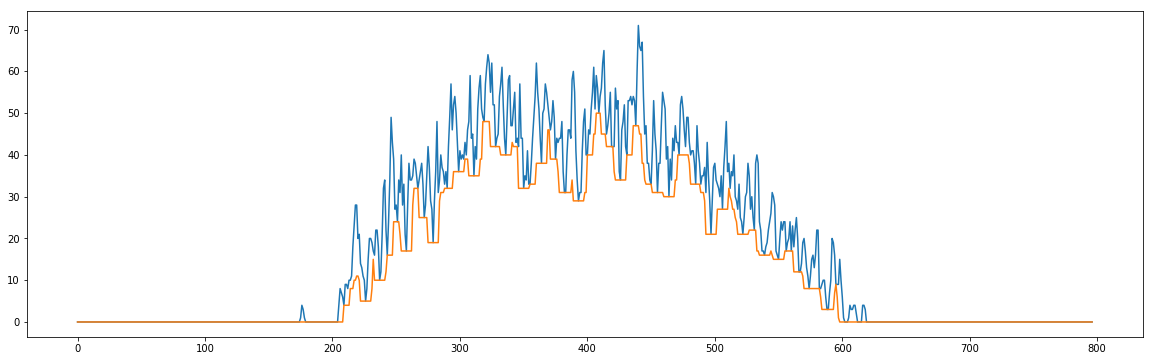

In [297]:
tmp = src9[45, :]
res = search_textline_1d(tmp, text_line_delta, min_maxima=10, max_minima=5, minmax_dist=10)
plt.figure(figsize=(20,6))
plt.plot(tmp)
plt.plot(scipy.ndimage.minimum_filter1d(tmp, size=text_line_delta, mode='nearest'))
plt.plot([x[0] for x in res], [x[1] for x in res], 'ro')

Wall time: 245 ms


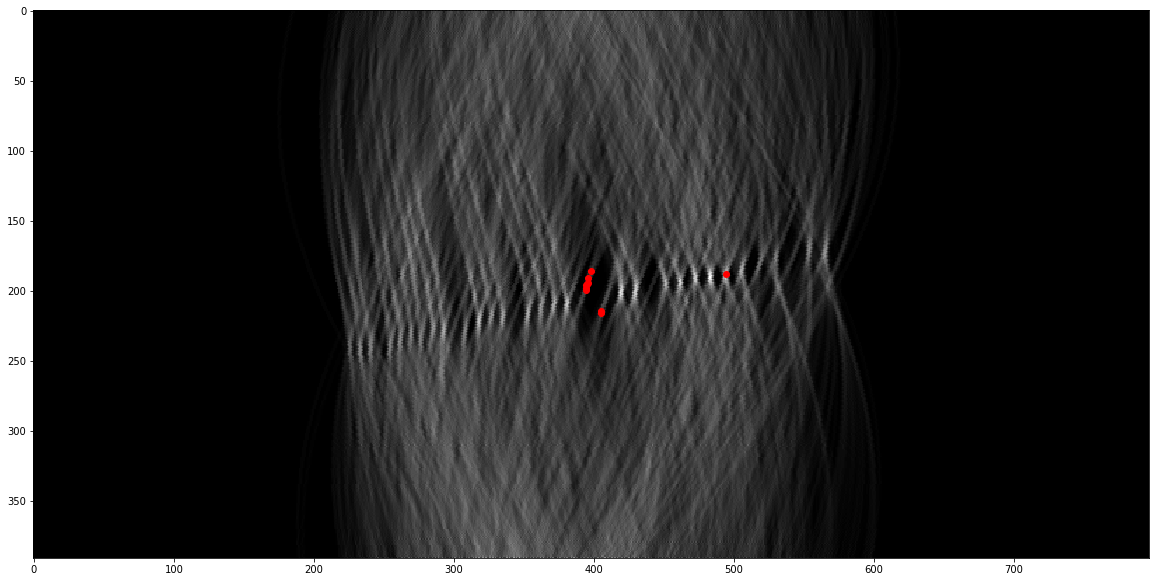

In [302]:
%%time
res = search_textline_2d(src9, text_line_delta, angle_width=3, min_maxima=10, max_minima=0, minmax_dist=40)

plt.figure(figsize=(20,20))
plt.imshow(src9, cmap='gray')
plt.plot([x[1] for x in res], [x[0] for x in res], 'ro')

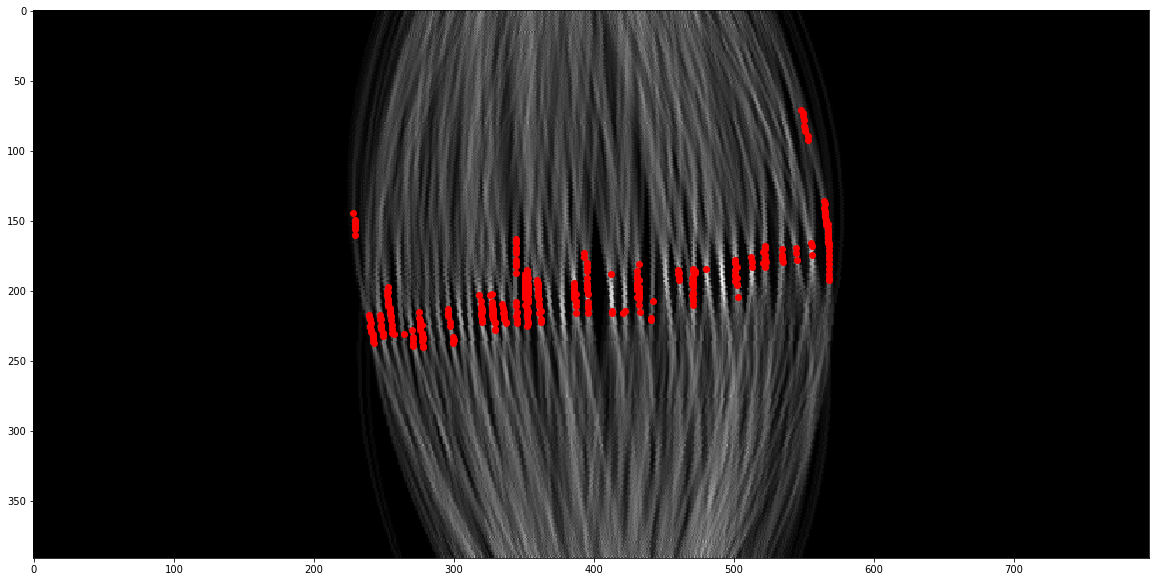

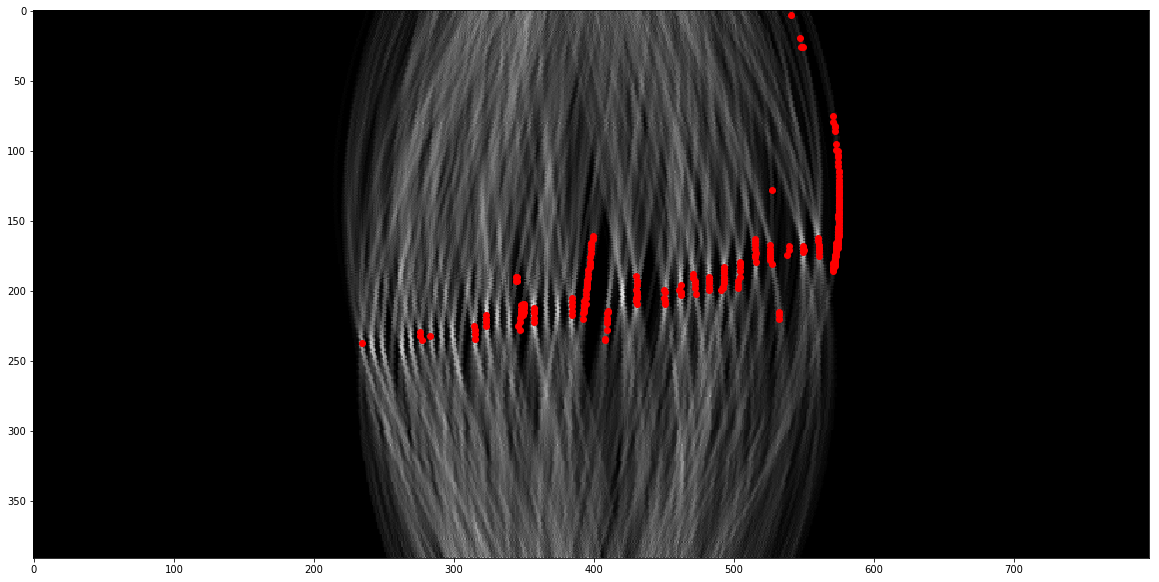

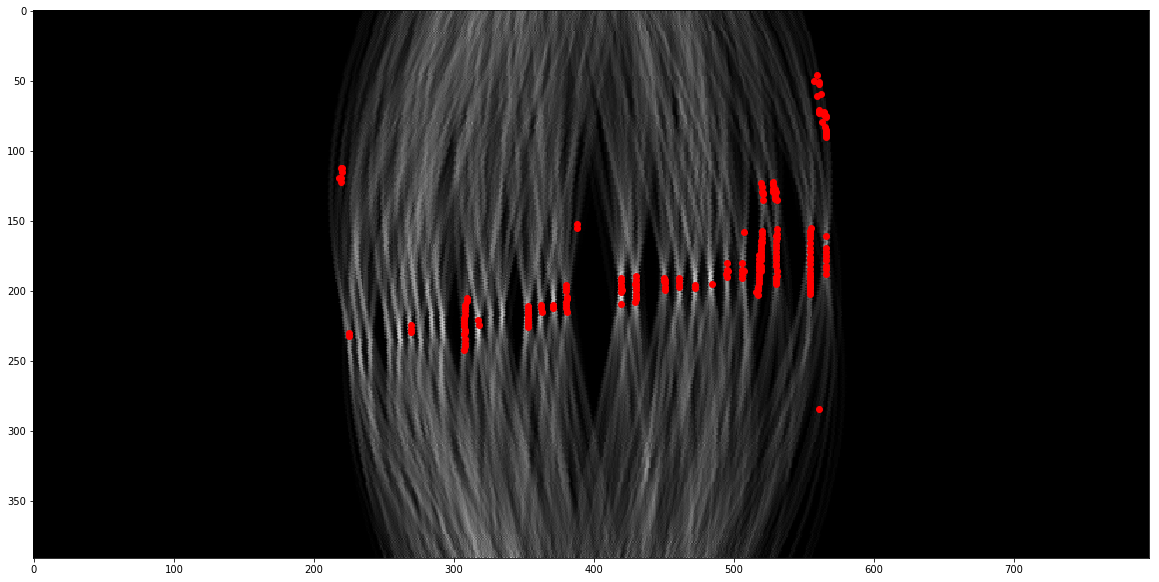

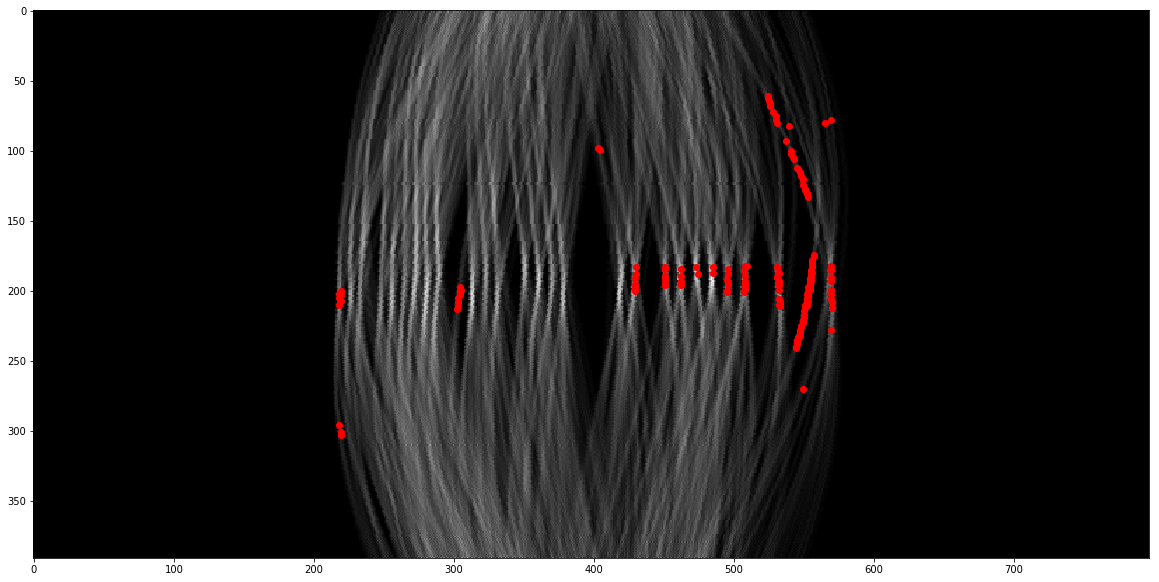

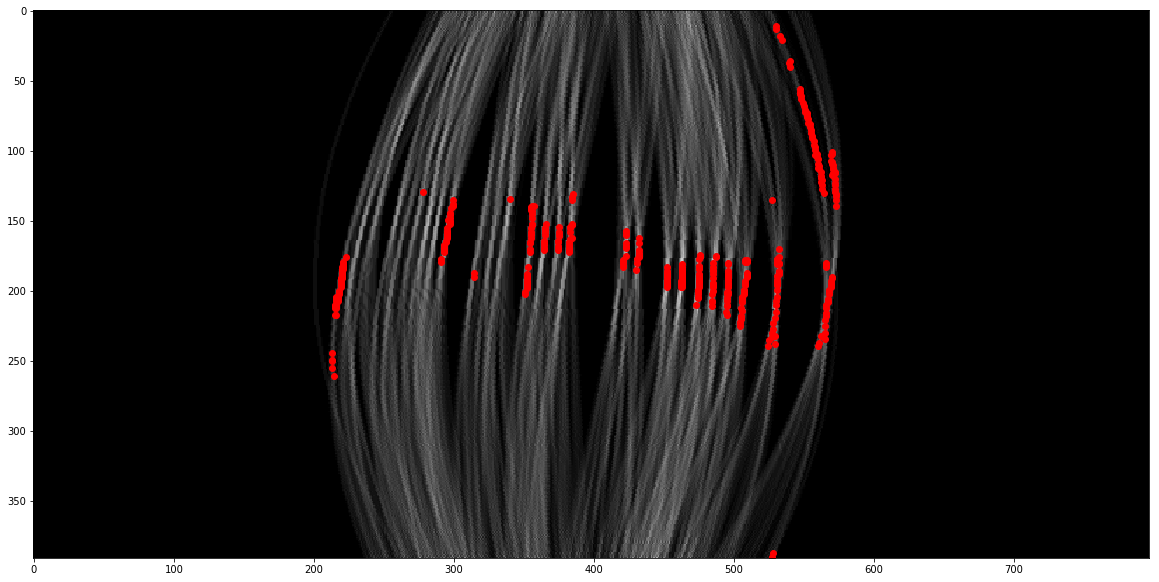

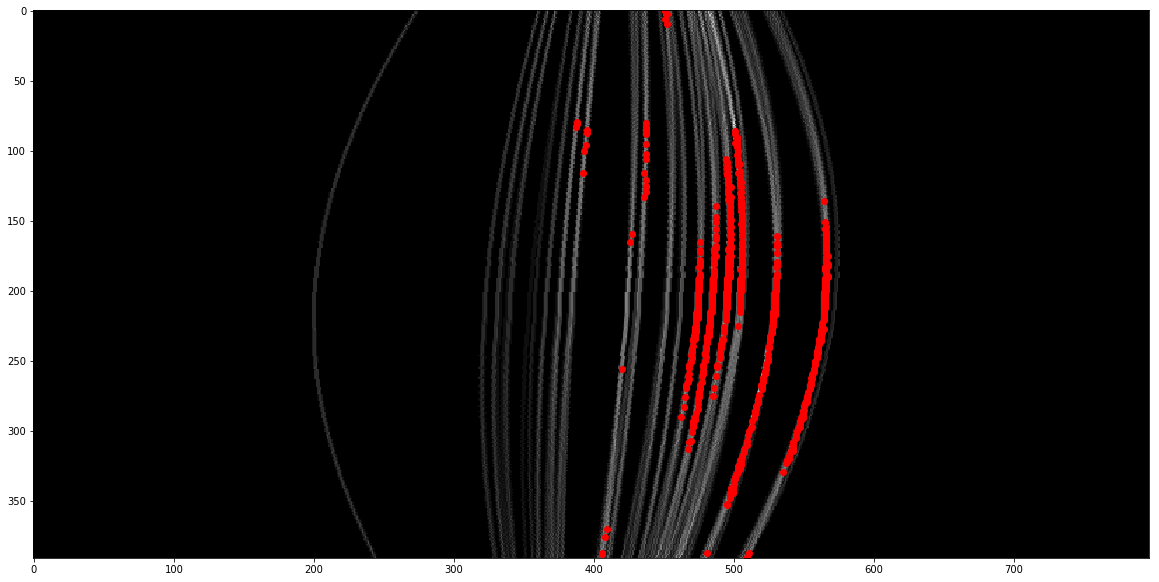

In [301]:
width = 100
stride = 50

src9v = [local_radon.calc_local_radon(rgrid, src8, 0, src8.shape[0], off, min(src8.shape[1], off+width)) for off in range(0, src8.shape[1], stride)]
res_v = [search_textline_2d(x, text_line_delta, angle_width=3, min_maxima=10, max_minima=0, minmax_dist=10) for x in src9v]

for i in range(len(src9v)):
    plt.figure(figsize=(20,20))
    plt.imshow(src9v[i], cmap='gray')
    plt.plot([x[1] for x in res_v[i]], [x[0] for x in res_v[i]], 'ro')
    
#plt.figure(figsize=(20,20))
#plt.imshow(np.sum(np.array(src9v), axis=0), cmap='gray')